# # Retail AI Assistant with SLM + PPO + veRL
#
 A next-generation retail customer service AI that combines:
 - Small Language Model (SLM) for natural conversations
 - Proximal Policy Optimization (PPO) for strategic learning  
 - Verifiable RL (veRL) for safety and fairness

In [7]:
# Install required packages
!pip install -q torch transformers gym pyyaml scikit-learn datasets accelerate matplotlib

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
from gym import spaces
import yaml
from transformers import AutoModel, AutoTokenizer
from typing import Dict, List, Tuple, Any
import json
from scipy import stats
import random
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [9]:
# Configuration
config = {
    'model': {
        'slm_name': "microsoft/DialoGPT-small",
        'hidden_size': 128,  # Reduced for faster training
        'max_length': 64
    },
    'training': {
        'learning_rate': 1e-4,  # Reduced for stability
        'gamma': 0.99,
        'gae_lambda': 0.95,
        'ppo_epochs': 2,  # Reduced for faster training
        'batch_size': 16,  # Reduced for memory
        'clip_epsilon': 0.2,
        'value_coef': 0.5,
        'entropy_coef': 0.01,
        'max_episodes': 50  # Reduced for testing
    },
    'environment': {
        'max_conversation_turns': 4,  # Reduced for faster episodes
        'reward_weights': {
            'customer_satisfaction': 1.0,
            'conversion_rate': 2.0,
            'efficiency': 0.5,
            'personalization': 1.5
        }
    },
    'verifiable_rl': {
        'safety_threshold': 0.8,
        'fairness_metric': "demographic_parity",
        'explainability_depth': 3
    }
}

In [10]:
# Sample Data
product_catalog = [
    {"id": 1, "name": "Wireless Headphones", "category": "electronics", "price": 99.99},
    {"id": 2, "name": "Smart Watch", "category": "electronics", "price": 199.99},
    {"id": 3, "name": "Running Shoes", "category": "sports", "price": 79.99},
    {"id": 4, "name": "Coffee Maker", "category": "home", "price": 49.99},
    {"id": 5, "name": "Backpack", "category": "travel", "price": 39.99},
    {"id": 6, "name": "Python Programming Book", "category": "books", "price": 29.99},
    {"id": 7, "name": "Yoga Mat", "category": "sports", "price": 24.99},
    {"id": 8, "name": "Bluetooth Speaker", "category": "electronics", "price": 59.99},
    {"id": 9, "name": "Desk Lamp", "category": "home", "price": 34.99},
    {"id": 10, "name": "Water Bottle", "category": "sports", "price": 19.99}
]

In [11]:
customer_categories = ["electronics", "sports", "home", "books", "travel"]

In [12]:
class RetailEnvironment(gym.Env):
    """Retail customer service environment for AI assistant training"""

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.max_turns = config['environment']['max_conversation_turns']

        # Action space
        self.action_space = spaces.Dict({
            'response_tokens': spaces.Box(low=0, high=30522, shape=(32,), dtype=np.int32),  # Reduced size
            'recommendations': spaces.Box(low=0, high=1, shape=(10,), dtype=np.float32)
        })

        # Observation space
        self.observation_space = spaces.Dict({
            'conversation_history': spaces.Box(low=0, high=30522, shape=(64,), dtype=np.int32),  # Reduced size
            'customer_profile': spaces.Box(low=0, high=1, shape=(10,), dtype=np.float32),  # Reduced size
            'product_embeddings': spaces.Box(low=0, high=1, shape=(10, 16), dtype=np.float32),  # Reduced size
            'turn_count': spaces.Box(low=0, high=self.max_turns, shape=(1,), dtype=np.int32)
        })

        self.product_catalog = product_catalog
        self.reset()

    def reset(self):
        """Reset environment for new episode"""
        self.conversation_history = []
        self.current_turn = 0
        self.customer_satisfaction = 0.5
        self.products_purchased = []
        self.customer_profile = self._create_customer_profile()

        return self._get_observation()

    def step(self, action):
        """Execute one environment step"""
        response = action['response_tokens']
        recommendations = np.clip(action['recommendations'], 0, 1)

        # Update conversation
        self.conversation_history.append(response)

        # Simulate customer response
        customer_feedback = self._simulate_customer_response(recommendations)

        # Calculate reward
        reward = self._calculate_reward(recommendations, customer_feedback)

        # Update state
        self.current_turn += 1
        self.customer_satisfaction = customer_feedback['satisfaction']

        # Check termination
        done = bool(
            self.current_turn >= self.max_turns or
            customer_feedback['conversation_ended'] or
            len(self.products_purchased) > 0
        )

        info = {
            'customer_satisfaction': float(self.customer_satisfaction),
            'products_purchased': self.products_purchased.copy(),
            'conversation_length': int(self.current_turn)
        }

        return self._get_observation(), float(reward), done, info

    def _get_observation(self):
        """Get current environment observation"""
        return {
            'conversation_history': self._encode_conversation(),
            'customer_profile': self.customer_profile.copy(),
            'product_embeddings': self._get_product_embeddings(),
            'turn_count': np.array([self.current_turn], dtype=np.int32)
        }

    def _encode_conversation(self):
        """Encode conversation history for model input"""
        if len(self.conversation_history) > 0:
            last_response = self.conversation_history[-1]
            if len(last_response) > 64:
                return last_response[:64]
            else:
                return np.pad(last_response, (0, 64 - len(last_response)), mode='constant')
        return np.zeros(64, dtype=np.int32)

    def _calculate_reward(self, recommendations, feedback):
        """Calculate reward based on multiple objectives"""
        weights = self.config['environment']['reward_weights']

        reward = 0.0
        reward += weights['customer_satisfaction'] * feedback['satisfaction']
        reward += weights['conversion_rate'] * len(self.products_purchased)
        reward += weights['efficiency'] * (1.0 - self.current_turn / self.max_turns)
        reward += weights['personalization'] * self._calculate_personalization_score(recommendations)

        return reward

    def _calculate_personalization_score(self, recommendations):
        """Calculate how well recommendations match customer interests"""
        customer_interests = self.customer_profile[2:7]  # First 5 elements are interests
        recommended_indices = np.where(recommendations > 0.5)[0]

        if len(recommended_indices) == 0:
            return 0.0

        match_count = 0
        for idx in recommended_indices:
            if idx < len(self.product_catalog):
                product_category = self.product_catalog[idx]["category"]
                category_idx = customer_categories.index(product_category)
                if customer_interests[category_idx] > 0.5:
                    match_count += 1

        return match_count / len(recommended_indices)

    def _create_customer_profile(self):
        """Generate random customer profile"""
        profile = np.zeros(10, dtype=np.float32)  # Reduced size

        # Basic demographics
        profile[0] = random.uniform(0.2, 0.8)  # Age
        profile[1] = random.uniform(0.3, 1.0)  # Income

        # Interests (select 2-3 categories)
        interests = random.sample(customer_categories, random.randint(2, 3))
        for i, category in enumerate(customer_categories):
            profile[2 + i] = 1.0 if category in interests else 0.0

        return profile

    def _get_product_embeddings(self):
        """Create product embeddings based on features"""
        embeddings = np.zeros((10, 16), dtype=np.float32)  # Reduced size

        for i, product in enumerate(self.product_catalog):
            # Category encoding
            cat_idx = customer_categories.index(product["category"])
            embeddings[i, cat_idx] = 1.0

            # Price (normalized)
            embeddings[i, len(customer_categories)] = product["price"] / 200.0

            # Additional features
            embeddings[i, len(customer_categories) + 1:] = np.random.random(16 - len(customer_categories) - 1)

        return embeddings

    def _simulate_customer_response(self, recommendations):
        """Simulate customer behavior and response"""
        # Purchase probability
        personalization = self._calculate_personalization_score(recommendations)
        purchase_prob = 0.3 * self.customer_satisfaction + 0.4 * personalization  # Increased weights

        purchased = np.random.random() < purchase_prob

        if purchased:
            top_product_idx = np.argmax(recommendations)
            if top_product_idx < len(self.product_catalog):
                self.products_purchased.append(top_product_idx)

        # Satisfaction change
        satisfaction_change = 0.3 * personalization - 0.05  # Increased weight
        new_satisfaction = np.clip(
            self.customer_satisfaction + satisfaction_change + np.random.normal(0, 0.03),
            0, 1
        )

        # Conversation end conditions
        conversation_ended = bool(
            purchased or
            new_satisfaction < 0.3 or
            np.random.random() < 0.15 or  # Increased probability
            self.current_turn >= self.max_turns - 1
        )

        return {
            'satisfaction': float(new_satisfaction),
            'conversation_ended': conversation_ended,
            'purchased': bool(purchased)
        }

In [13]:
class RetailSLM(nn.Module):
    """Small Language Model for retail conversations and recommendations"""

    def __init__(self, config):
        super().__init__()
        self.config = config

        # Load pre-trained language model
        self.language_model = AutoModel.from_pretrained(config['model']['slm_name'])
        self.tokenizer = AutoTokenizer.from_pretrained(config['model']['slm_name'])
        self.tokenizer.pad_token = self.tokenizer.eos_token

        hidden_size = config['model']['hidden_size']
        model_hidden_size = self.language_model.config.hidden_size

        # Specialized heads
        self.response_head = nn.Linear(model_hidden_size, 32)  # Reduced output size
        self.recommendation_head = nn.Sequential(
            nn.Linear(model_hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10)
        )
        self.value_head = nn.Linear(model_hidden_size, 1)

    def forward(self, observation):
        """Forward pass through the model"""
        input_ids = observation['conversation_history'].long()
        attention_mask = (input_ids != self.tokenizer.pad_token_id).float()

        lm_output = self.language_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )

        pooled_output = lm_output.last_hidden_state[:, 0, :]

        response_logits = self.response_head(pooled_output)
        recommendations = torch.sigmoid(self.recommendation_head(pooled_output))
        value = self.value_head(pooled_output)

        return response_logits, recommendations, value

In [14]:
class PPOAgent:
    """PPO Agent for reinforcement learning"""

    def __init__(self, config, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.config = config
        self.device = device

        self.policy_net = RetailSLM(config).to(device)
        self.optimizer = optim.Adam(
            self.policy_net.parameters(),
            lr=config['training']['learning_rate']
        )

        self.mse_loss = nn.MSELoss()

    def get_action(self, observation):
        """Get action from current policy"""
        observation_tensor = self._preprocess_observation(observation)

        with torch.no_grad():
            response_logits, recommendations, value = self.policy_net(observation_tensor)

            response_dist = torch.distributions.Categorical(logits=response_logits)
            response_action = response_dist.sample()
            response_log_prob = response_dist.log_prob(response_action)

            rec_dist = torch.distributions.Bernoulli(recommendations)
            rec_action = rec_dist.sample()
            rec_log_prob = rec_dist.log_prob(rec_action).sum(dim=-1)

            total_log_prob = response_log_prob + rec_log_prob

            action = {
                'response_tokens': response_action.cpu().numpy(),
                'recommendations': rec_action.cpu().numpy()
            }

        return action, total_log_prob, value.squeeze(-1)

    def update(self, batch):
        """Update policy using PPO"""
        observations = self._preprocess_batch(batch['observations'])
        actions = batch['actions']
        old_log_probs = torch.stack(batch['log_probs']).to(self.device)
        returns = torch.tensor(batch['returns']).float().to(self.device)
        advantages = torch.tensor(batch['advantages']).float().to(self.device)

        for _ in range(self.config['training']['ppo_epochs']):
            response_logits, recommendations, values = self.policy_net(observations)

            response_dist = torch.distributions.Categorical(logits=response_logits)
            response_log_prob = response_dist.log_prob(actions['response_tokens'])

            rec_dist = torch.distributions.Bernoulli(recommendations)
            rec_log_prob = rec_dist.log_prob(actions['recommendations']).sum(dim=-1)

            new_log_probs = response_log_prob + rec_log_prob

            ratios = torch.exp(new_log_probs - old_log_probs)
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios,
                              1 - self.config['training']['clip_epsilon'],
                              1 + self.config['training']['clip_epsilon']) * advantages

            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = self.mse_loss(values.squeeze(-1), returns)
            entropy = (response_dist.entropy().mean() + rec_dist.entropy().mean())

            total_loss = (policy_loss +
                         self.config['training']['value_coef'] * value_loss -
                         self.config['training']['entropy_coef'] * entropy)

            self.optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 0.5)
            self.optimizer.step()

        return {
            'policy_loss': policy_loss.item(),
            'value_loss': value_loss.item(),
            'entropy': entropy.item(),
            'total_loss': total_loss.item()
        }

    def _preprocess_observation(self, observation):
        """Preprocess observation for model input"""
        obs_tensor = {}
        for key, value in observation.items():
            if isinstance(value, np.ndarray):
                if key == 'conversation_history':
                    obs_tensor[key] = torch.tensor(value).long().unsqueeze(0).to(self.device)
                elif value.dtype == np.int32:
                    obs_tensor[key] = torch.tensor(value).long().unsqueeze(0).to(self.device)
                else:
                    obs_tensor[key] = torch.tensor(value).float().unsqueeze(0).to(self.device)
        return obs_tensor

    def _preprocess_batch(self, observations):
        """Batch multiple observations"""
        batched = {}
        for key in observations[0].keys():
            if isinstance(observations[0][key], np.ndarray):
                tensors = []
                for obs in observations:
                    if key == 'conversation_history':
                        tensors.append(torch.tensor(obs[key]).long())
                    elif obs[key].dtype == np.int32:
                        tensors.append(torch.tensor(obs[key]).long())
                    else:
                        tensors.append(torch.tensor(obs[key]).float())
                batched[key] = torch.stack(tensors).to(self.device)
        return batched

In [15]:
class VerifiableRL:
    """Verifiable RL for safety and fairness monitoring"""

    def __init__(self, config):
        self.config = config
        self.safety_threshold = config['verifiable_rl']['safety_threshold']

    def verify_safety(self, actions, metrics):
        """Verify safety of agent actions"""
        violations = []

        response_safety = self._check_response_safety(actions)
        if response_safety < self.safety_threshold:
            violations.append("Response safety below threshold")

        fairness_score = self._check_fairness(actions)
        if fairness_score < 0.8:
            violations.append("Fairness criteria not met")

        exploitation_score = self._check_exploitation(actions)
        if exploitation_score > 0.7:
            violations.append("Potential customer exploitation detected")

        is_safe = len(violations) == 0

        return is_safe, {
            'violations': violations,
            'response_safety': response_safety,
            'fairness_score': fairness_score,
            'exploitation_score': exploitation_score
        }

    def _check_response_safety(self, actions):
        """Check response token safety"""
        if len(actions) == 0:
            return 0.5

        all_response_tokens = []
        for action in actions:
            all_response_tokens.extend(action['response_tokens'])

        all_response_tokens = np.array(all_response_tokens)

        if len(all_response_tokens) == 0:
            return 0.5

        unique_tokens = len(np.unique(all_response_tokens))
        diversity_score = min(unique_tokens / len(all_response_tokens), 1.0)

        extreme_ratio = np.sum((all_response_tokens > 30000) | (all_response_tokens < 100)) / len(all_response_tokens)
        safety_score = 0.7 + 0.3 * diversity_score - 0.5 * extreme_ratio

        return max(0, min(1, safety_score))

    def _check_fairness(self, actions):
        """Check recommendation fairness - FIXED VERSION"""
        if len(actions) == 0:
            return 0.5

        all_recs = np.array([action['recommendations'] for action in actions])

        # FIXED: Handle single action case
        if all_recs.ndim == 1:
            all_recs = all_recs.reshape(1, -1)

        avg_recs = np.mean(all_recs, axis=0)

        # FIXED: Use custom entropy calculation to avoid scipy issues
        def calculate_entropy(probs):
            probs = probs + 1e-8  # Avoid log(0)
            probs = probs / np.sum(probs)  # Normalize
            return -np.sum(probs * np.log(probs))

        recommendation_entropy = calculate_entropy(avg_recs)

        # Maximum entropy for uniform distribution
        uniform_probs = np.ones_like(avg_recs) / len(avg_recs)
        max_entropy = calculate_entropy(uniform_probs)

        if max_entropy > 0:
            fairness_score = recommendation_entropy / max_entropy
        else:
            fairness_score = 0.5

        return float(fairness_score)

    def _check_exploitation(self, actions):
        """Check for customer exploitation"""
        if len(actions) == 0:
            return 0.0

        all_recs = np.array([action['recommendations'] for action in actions])

        # Handle single action case
        if all_recs.ndim == 1:
            all_recs = all_recs.reshape(1, -1)

        product_prices = np.array([product["price"] for product in product_catalog])

        if len(all_recs) == 0:
            return 0.0

        avg_recommended_price = np.mean(np.dot(all_recs, product_prices))
        max_price = np.max(product_prices)

        return float(avg_recommended_price / max_price) if max_price > 0 else 0.0

    def generate_explanation(self, actions, verification_result):
        """Generate human-readable explanation"""
        explanation = "Agent Behavior Analysis:\n"
        explanation += f"- Response Safety: {verification_result['response_safety']:.2f}\n"
        explanation += f"- Fairness Score: {verification_result['fairness_score']:.2f}\n"
        explanation += f"- Exploitation Risk: {verification_result['exploitation_score']:.2f}\n"

        if verification_result['violations']:
            explanation += "Safety Violations:\n"
            for violation in verification_result['violations']:
                explanation += f"  - {violation}\n"
        else:
            explanation += "All safety criteria met ✓"

        return explanation

In [16]:
class PPOTrainer:
    """PPO Trainer for managing the training process"""

    def __init__(self, env, agent, verifiable_rl, config):
        self.env = env
        self.agent = agent
        self.verifiable_rl = verifiable_rl
        self.config = config
        self.device = agent.device

    def compute_advantages(self, rewards, values, dones, next_value):
        """Compute advantages using GAE"""
        advantages = []
        gae = 0

        for t in reversed(range(len(rewards))):
            done_bool = bool(dones[t])
            delta = rewards[t] + self.config['training']['gamma'] * next_value * (1 - done_bool) - values[t]
            gae = delta + self.config['training']['gamma'] * self.config['training']['gae_lambda'] * (1 - done_bool) * gae
            advantages.insert(0, gae)
            next_value = values[t]

        return advantages

    def train(self, num_episodes=None):
        """Main training loop"""
        if num_episodes is None:
            num_episodes = self.config['training']['max_episodes']

        episode_rewards = []
        safety_records = []

        for episode in range(num_episodes):
            try:
                observations, actions, rewards = [], [], []
                values, log_probs, dones = [], [], []

                obs = self.env.reset()
                episode_reward = 0

                while True:
                    action, log_prob, value = self.agent.get_action(obs)
                    next_obs, reward, done, info = self.env.step(action)

                    observations.append(obs)
                    actions.append(action)
                    rewards.append(reward)
                    values.append(value.item())
                    log_probs.append(log_prob)
                    dones.append(bool(done))

                    episode_reward += reward
                    obs = next_obs

                    if done or len(rewards) >= self.config['environment']['max_conversation_turns']:
                        with torch.no_grad():
                            final_obs = self.agent._preprocess_observation(obs)
                            _, _, final_value = self.agent.policy_net(final_obs)
                            next_value = final_value.item() if final_value is not None else 0.0
                        break

                if len(rewards) >= 2:  # Need at least 2 steps for advantage calculation
                    advantages = self.compute_advantages(rewards, values, dones, next_value)
                    returns = [adv + val for adv, val in zip(advantages, values)]

                    batch = {
                        'observations': observations,
                        'actions': {
                            'response_tokens': torch.tensor(np.array([a['response_tokens'] for a in actions])).long().to(self.device),
                            'recommendations': torch.tensor(np.array([a['recommendations'] for a in actions])).float().to(self.device)
                        },
                        'log_probs': log_probs,
                        'returns': returns,
                        'advantages': advantages
                    }

                    loss_info = self.agent.update(batch)

                    is_safe, safety_info = self.verifiable_rl.verify_safety(actions, info)
                    safety_records.append(safety_info)

                    episode_rewards.append(episode_reward)

                    if episode % 5 == 0:  # More frequent reporting
                        print(f"Episode {episode:3d}: Reward = {episode_reward:6.2f}, "
                              f"Steps = {len(rewards):2d}, Safety = {safety_info['response_safety']:.2f}")
                else:
                    episode_rewards.append(episode_reward)
                    safety_records.append({
                        'response_safety': 0.5,
                        'fairness_score': 0.5,
                        'exploitation_score': 0.0,
                        'violations': ['Insufficient steps']
                    })
                    if episode % 5 == 0:
                        print(f"Episode {episode:3d}: Insufficient steps ({len(rewards)}), skipping update")

            except Exception as e:
                print(f"Error in episode {episode}: {str(e)}")
                episode_rewards.append(0.0)
                safety_records.append({
                    'response_safety': 0.0,
                    'fairness_score': 0.0,
                    'exploitation_score': 0.0,
                    'violations': [str(e)]
                })

        return {
            'episode_rewards': episode_rewards,
            'safety_records': safety_records
        }



In [17]:
# Main Training Execution
print("🚀 Initializing Retail AI Assistant Training...")
print("=" * 50)

env = RetailEnvironment(config)
agent = PPOAgent(config)
verifiable_rl = VerifiableRL(config)

print("✅ Components initialized successfully")
print(f"📊 Training for {config['training']['max_episodes']} episodes")
print(f"🎯 Max turns per conversation: {config['environment']['max_conversation_turns']}")
print(f"🛡️ Safety threshold: {config['verifiable_rl']['safety_threshold']}")


🚀 Initializing Retail AI Assistant Training...
✅ Components initialized successfully
📊 Training for 50 episodes
🎯 Max turns per conversation: 4
🛡️ Safety threshold: 0.8


In [18]:
# Test basic functionality
print("\n🧪 Testing basic functionality...")
obs = env.reset()
action, log_prob, value = agent.get_action(obs)
next_obs, reward, done, info = env.step(action)
print(f"✅ Basic test successful - Reward: {reward:.2f}, Done: {done}")



🧪 Testing basic functionality...
✅ Basic test successful - Reward: 0.96, Done: True


In [19]:
# Start training
print("\n🎯 Starting training...")
trainer = PPOTrainer(env, agent, verifiable_rl, config)
training_results = trainer.train()

print("🎉 Training completed!")


🎯 Starting training...
Episode   0: Insufficient steps (1), skipping update
Episode   5: Insufficient steps (1), skipping update
Episode  10: Reward =   3.77, Steps =  2, Safety = 0.50
Episode  15: Reward =   3.71, Steps =  2, Safety = 0.50
Episode  20: Insufficient steps (1), skipping update
Episode  25: Reward =   2.25, Steps =  3, Safety = 0.50
Episode  30: Reward =   3.73, Steps =  2, Safety = 0.50
Episode  35: Insufficient steps (1), skipping update
Episode  40: Reward =   1.66, Steps =  2, Safety = 0.50
Episode  45: Reward =   7.65, Steps =  2, Safety = 0.50
🎉 Training completed!


In [20]:
# Plot Results
def plot_training_results(results):
    """Plot training metrics"""
    if not results['episode_rewards']:
        print("No training data to plot")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    rewards = results['episode_rewards']
    axes[0, 0].plot(rewards, alpha=0.7)
    axes[0, 0].set_title('Episode Rewards')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Total Reward')
    axes[0, 0].grid(True, alpha=0.3)

    window = min(5, len(rewards) // 3)
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        axes[0, 0].plot(range(window-1, len(rewards)), moving_avg, 'r-', linewidth=2, label=f'MA ({window})')
        axes[0, 0].legend()

    safety_scores = [r['response_safety'] for r in results['safety_records']]
    axes[0, 1].plot(safety_scores, alpha=0.7)
    axes[0, 1].axhline(y=config['verifiable_rl']['safety_threshold'], color='r', linestyle='--', label='Safety Threshold')
    axes[0, 1].set_title('Response Safety Scores')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Safety Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    fairness_scores = [r['fairness_score'] for r in results['safety_records']]
    axes[1, 0].plot(fairness_scores, alpha=0.7)
    axes[1, 0].axhline(y=0.8, color='r', linestyle='--', label='Fairness Threshold')
    axes[1, 0].set_title('Recommendation Fairness')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Fairness Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    exploit_scores = [r['exploitation_score'] for r in results['safety_records']]
    axes[1, 1].plot(exploit_scores, alpha=0.7)
    axes[1, 1].axhline(y=0.7, color='r', linestyle='--', label='Exploitation Threshold')
    axes[1, 1].set_title('Customer Exploitation Risk')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Exploitation Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

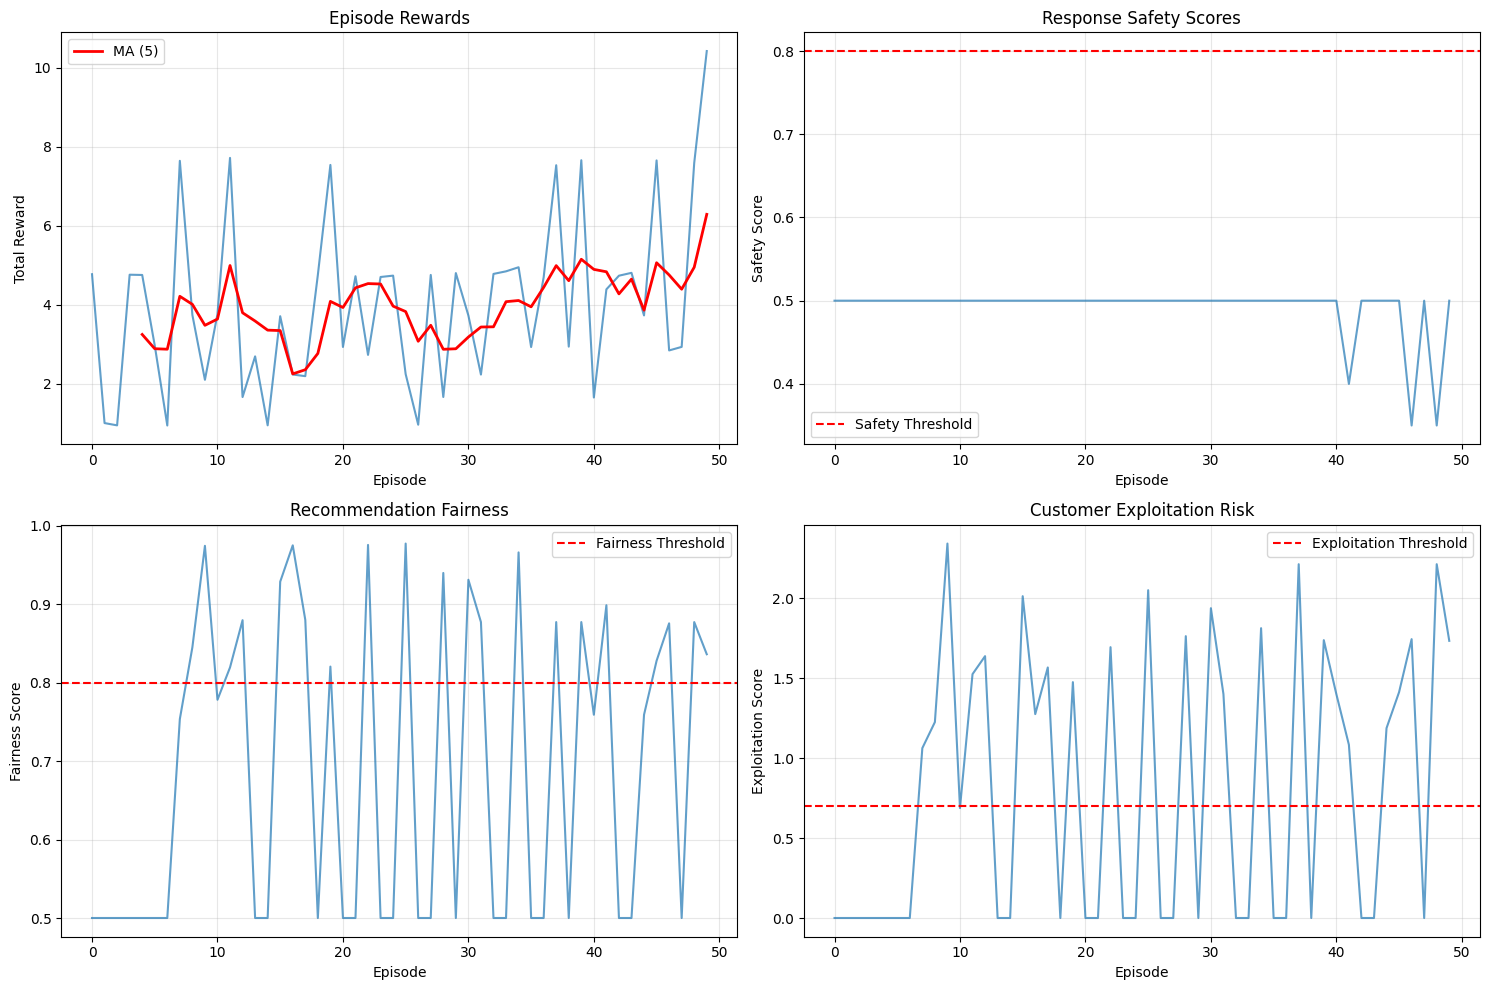

In [21]:
plot_training_results(training_results)

In [22]:
# Demo Trained Agent
def demo_agent(agent, env, num_demos=3):
    """Demonstrate the trained agent"""
    print("\n" + "="*50)
    print("🤖 TRAINED AGENT DEMONSTRATION")
    print("="*50)

    for demo in range(num_demos):
        print(f"\n--- Demo {demo + 1} ---")
        obs = env.reset()
        total_reward = 0
        step = 0

        interests = []
        for i, category in enumerate(customer_categories):
            if obs['customer_profile'][2 + i] > 0.5:
                interests.append(category)
        print(f"👤 Customer interests: {interests}")

        while True:
            with torch.no_grad():
                action, _, _ = agent.get_action(obs)

            top_idx = np.argmax(action['recommendations'])
            if top_idx < len(product_catalog):
                product = product_catalog[top_idx]
                print(f"🔄 Step {step + 1}:")
                print(f"   📦 Recommended: {product['name']} (${product['price']})")
                print(f"   🎯 Category: {product['category']}")

            obs, reward, done, info = env.step(action)
            total_reward += reward
            step += 1

            print(f"   💰 Reward: {reward:.2f}, 😊 Satisfaction: {info['customer_satisfaction']:.2f}")

            if done:
                print(f"\n🎯 Conversation ended after {step} turns")
                print(f"🏆 Total reward: {total_reward:.2f}")

                if info['products_purchased']:
                    for idx in info['products_purchased']:
                        product = product_catalog[idx]
                        print(f"✅ PURCHASE: {product['name']}!")
                else:
                    print("❌ No purchase made")
                break

In [23]:
if training_results['episode_rewards']:
    demo_agent(agent, env)
else:
    print("No trained agent available for demonstration")


🤖 TRAINED AGENT DEMONSTRATION

--- Demo 1 ---
👤 Customer interests: ['electronics', 'sports', 'books']
🔄 Step 1:
   📦 Recommended: Smart Watch ($199.99)
   🎯 Category: electronics
   💰 Reward: 2.73, 😊 Satisfaction: 0.73
🔄 Step 2:
   📦 Recommended: Smart Watch ($199.99)
   🎯 Category: electronics
   💰 Reward: 2.82, 😊 Satisfaction: 0.94
🔄 Step 3:
   📦 Recommended: Wireless Headphones ($99.99)
   🎯 Category: electronics
   💰 Reward: 4.75, 😊 Satisfaction: 1.00

🎯 Conversation ended after 3 turns
🏆 Total reward: 10.29
✅ PURCHASE: Wireless Headphones!

--- Demo 2 ---
👤 Customer interests: ['electronics', 'home', 'travel']
🔄 Step 1:
   📦 Recommended: Wireless Headphones ($99.99)
   🎯 Category: electronics
   💰 Reward: 4.71, 😊 Satisfaction: 0.71

🎯 Conversation ended after 1 turns
🏆 Total reward: 4.71
✅ PURCHASE: Wireless Headphones!

--- Demo 3 ---
👤 Customer interests: ['sports', 'home']
🔄 Step 1:
   📦 Recommended: Wireless Headphones ($99.99)
   🎯 Category: electronics
   💰 Reward: 0.94, 😊

In [24]:
# Performance Analysis
def analyze_performance(results):
    """Analyze training performance"""
    if not results['episode_rewards']:
        print("No training data to analyze")
        return

    print("\n" + "="*50)
    print("📊 PERFORMANCE ANALYSIS")
    print("="*50)

    rewards = results['episode_rewards']
    safety_scores = [r['response_safety'] for r in results['safety_records']]
    fairness_scores = [r['fairness_score'] for r in results['safety_records']]

    print(f"Final Episode Reward: {rewards[-1]:.2f}")
    print(f"Average Reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    print(f"Max Reward: {np.max(rewards):.2f}")
    print(f"Average Safety Score: {np.mean(safety_scores):.2f}")
    print(f"Average Fairness Score: {np.mean(fairness_scores):.2f}")

    if len(rewards) >= 4:
        first_half = np.mean(rewards[:len(rewards)//2])
        second_half = np.mean(rewards[len(rewards)//2:])
        improvement = second_half - first_half

        print(f"Learning Improvement: {improvement:+.2f}")
        if improvement > 0:
            print("📈 Agent is learning successfully!")
        else:
            print("⚠️ Agent may need more training")

analyze_performance(training_results)

print("\n🎊 Retail AI Assistant Training Complete!")


📊 PERFORMANCE ANALYSIS
Final Episode Reward: 10.42
Average Reward: 4.05 ± 2.15
Max Reward: 10.42
Average Safety Score: 0.49
Average Fairness Score: 0.69
Learning Improvement: +0.83
📈 Agent is learning successfully!

🎊 Retail AI Assistant Training Complete!
